In [1]:
import Parity_Data_Generator
import numpy as np
from pyESN import ESN
import time

N = 5000   # number of datapoints
n = 3       # n-parity
timescale = 50
rng = np.random.RandomState(42)



start_time = time.time()
# produce Data
bits, parity, target = Parity_Data_Generator.generateParityData(N, n, randomstate=rng)

# Divide in training and test data
traintest_cutoff = int(np.ceil(0.7 * len(bits)))
train_bits, test_bits = bits[:traintest_cutoff], bits[traintest_cutoff:]
train_parity, test_parity = parity[:traintest_cutoff], parity[traintest_cutoff:]
train_targets, test_targets = target[:traintest_cutoff], target[traintest_cutoff:]

print("--- %s seconds ---" % (time.time() - start_time))

In [2]:
def runSomeConfigs(spectral_rad, leak_r, train_b, test_b, train_p, test_p, n_neurons):
#     print("Spectral-radius:",spectral_rad, "leak-rate:", leak_r)
    nParityESN = ESN(n_inputs=1,
                          n_outputs=1,
                          n_reservoir=n_neurons,  # from 200 onwards test error decreases significantly
                          spectral_radius=spectral_rad,  # high spectral rad is better (high fluctuations 0->1->0)
                          leak_rate= leak_r,   # adjust leak_rate
                          sparsity=0.95,
                          noise=0.01,
                          input_shift=0,
                          input_scaling=3,  # 3 seems to be fine. Maybe use lower
                          teacher_forcing=False,
                          teacher_scaling=1.12,
                          teacher_shift=-0.7,
                          random_state=rng,
                          silent=False)
    # print(np.shape(bits),np.shape(parity),np.shape(target))
    nParityESN.fit(train_b, train_p)
    pred_test = nParityESN.predict(test_b)

    #### not rounding
    predictedParity = pred_test # not rounding
    #### Rounding
#     better_pred_test = []           # Maybe don't round and return "true" results from pred_test
#     for x in pred_test:
#         better_pred_test.append(0 if x < 0.5 else 1)
#     predictedParity = np.array(better_pred_test).reshape(-1,1)
#     print(test_parity[40030:40100].reshape(-1))
#     print(predictedParity[40030:40100].reshape(-1))
    
    print("Testing error")
    test_error = np.sqrt(np.mean((predictedParity - test_p) ** 2))
    print(test_error)
    return test_error



In [3]:
def produceTrainingData(i):
    bits, parity, target = Parity_Data_Generator.generateParityData(N, n, timescale=timescale, 
                                                                    randomstate=np.random.RandomState(i))

    # Divide in training and test data
    traintest_cutoff = int(np.ceil(0.7 * len(bits)))
    train_bits, test_bits = bits[:traintest_cutoff], bits[traintest_cutoff:]
    train_parity, test_parity = parity[:traintest_cutoff], parity[traintest_cutoff:]
#     train_targets, test_targets = target[:traintest_cutoff], target[traintest_cutoff:]
    return train_bits, test_bits, train_parity, test_parity


In [4]:
trials = 1
n_neurons_slow = [200,300,400,500]
# n_neurons_slow = [200]

l_rate = np.linspace(0.1, 1, num=10)
# l_rate =[0.2]
# l_rate = [0.1,0.2,0.3]

# sp_rad = np.linspace(0.9, 1.0, num=5)
sp_rad = np.linspace(0.1, 1, num=10)
# sp_rad = [0.8]

run_time = time.time()
iterations, iterationcount = trials*len(n_neurons_slow)*len(sp_rad)*len(l_rate), 0

neurons_slow_error = []
for current_slow_neurons in n_neurons_slow:
    all_errors = [{} for _ in range(trials)] # empty dict
    for i in range(trials):
        errors = []
        # produce training and testing data
        train_bits, test_bits, train_parity, test_parity = produceTrainingData(i)
        for l in l_rate:
            for s in sp_rad:
                print("Neurons:", current_slow_neurons,"Leak-rate:",l,"Spectral-radius:",s)
                errors.append(runSomeConfigs(s,l, train_bits, test_bits, train_parity, test_parity, current_slow_neurons))
                iterationcount = iterationcount + 1
                print("--- Progress: {:.2f}% --- {:.2f} minutes ---".format(iterationcount/iterations*100, ((time.time() - run_time)/60) ))
        ## Save leak-rate,spectral-radius and error in dictionary
        all_errors[i] = errors

    ### Average errors
    errors_averaged_over_trials = np.zeros(100)
    for i in range(len(all_errors)):
        e = all_errors[i]
        errors_averaged_over_trials = np.add(errors_averaged_over_trials, np.array(e))
    errors_averaged_over_trials = np.divide(errors_averaged_over_trials, trials)
    
    neurons_slow_error.append(errors_averaged_over_trials)
            
print("Total time for Testbench:")
print("--- {:.2f} seconds ---".format(time.time() - run_time))
print("--- {:.2f} minutes ---".format(((time.time() - run_time)/60)))

Neurons: 200 Leak-rate: 0.1 Spectral-radius: 0.1
harvesting states...
fitting...
training error:
0.462324337399
Testing error
0.458679504403
--- Progress: 1.00% --- 0.22 minutes ---
Neurons: 200 Leak-rate: 0.1 Spectral-radius: 0.2
harvesting states...
fitting...
training error:
0.447148930255
Testing error
0.444430091021
--- Progress: 2.00% --- 0.45 minutes ---
Neurons: 200 Leak-rate: 0.1 Spectral-radius: 0.3
harvesting states...
fitting...
training error:
0.420897106747
Testing error
0.421535127694
--- Progress: 3.00% --- 0.67 minutes ---
Neurons: 200 Leak-rate: 0.1 Spectral-radius: 0.4
harvesting states...
fitting...
training error:
0.45356030541
Testing error
0.458051524725
--- Progress: 4.00% --- 0.91 minutes ---
Neurons: 200 Leak-rate: 0.1 Spectral-radius: 0.5
harvesting states...
fitting...
training error:
0.41918670501
Testing error
0.428997388981
--- Progress: 5.00% --- 1.13 minutes ---
Neurons: 200 Leak-rate: 0.1 Spectral-radius: 0.6
harvesting states...
fitting...
training er

In [39]:
import pickle
#### Save Data
with open('datasaveAverageSlowDifferentNeuronSizes.p', 'wb') as outputFile:
    pickle.dump(neurons_slow_error, outputfile)
    pickle.dump(n_neurons_slow, outputFile)
    pickle.dump(trials, outputFile)
    pickle.dump(l_rate, outputFile)
    pickle.dump(sp_rad, outputFile)
#### Load Data
# with open('datasaveAverageSlowDifferentNeuronSizes.p', 'rb') as inputFile:
#     neurons_slow_error = pickle.load(inputFile)
#     n_neurons_slow = pickle.load(inputFile)
#     trials = pickle.load(inputFile)
#     l_rate = pickle.load(inputFile)
#     sp_rad = pickle.load(inputFile)

In [5]:
import plotly.plotly as py
import plotly.graph_objs as go

# c= ['hsl('+str(h)+',50%'+',50%)' for h in np.linspace(0, 360, len(all_errors))]
# c= ["blue", "orange", "green", "cyan", "yellow", "magenta", "red", "black"]

x = np.repeat(l_rate,len(l_rate))
y = np.tile(sp_rad, len(sp_rad))
z = neurons_slow_error[0]
trace1 = go.Scatter3d(
    x=x,
    y=y,
    z=z,
    name=("Averaged over", trials ,"Trials"),
    mode='markers',
    marker=dict(
        size=7,
        color=z,                # set color to an array/list of desired values
        colorscale='Viridis',   # choose a colorscale
        opacity=0.8
    )
)

data = [trace1]
layout = go.Layout(
#     margin=dict(
#         l=0,
#         r=0,
#         b=0,
#         t=0
#     ),
#     go.zaxis=dict(
#         range=[0, 0.8]
#     ),
    scene=go.Scene(
        xaxis=go.XAxis(title='x = Leak-Rate'),
        yaxis=go.YAxis(title='y = Spectral Radius'),
        zaxis=go.ZAxis(title='z = Error')
        )
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='SlowESN average Error')

In [42]:
data = [
     go.Contour(
        z=errors_averaged_over_trials.reshape(10,10).T,
        x=l_rate,
        y=sp_rad,
        colorscale='Jet',
    )]
py.iplot(data)

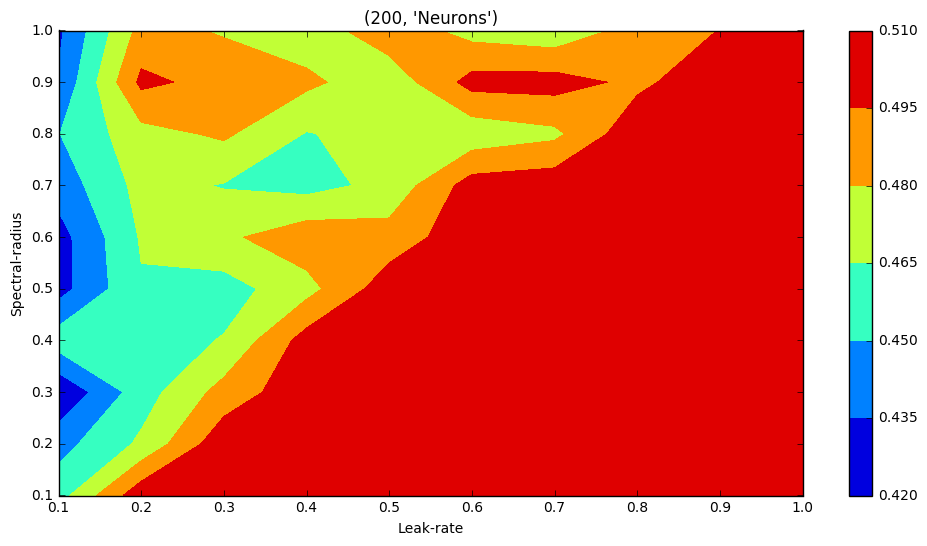

In [16]:
from matplotlib import pyplot
%matplotlib inline
for p in range(len(n_neurons_slow)):
    pyplot.figure(figsize=(12,6))
    pyplot.subplot(p+1,1,len(n_neurons_slow))
    pyplot.contourf(np.repeat(l_rate,len(l_rate)).reshape(10,10),
                    np.tile(sp_rad, len(sp_rad)).reshape(10,10),neurons_slow_error[p].reshape(10,10))
    pyplot.title((n_neurons_slow[p],"Neurons"))
    pyplot.xlabel("Leak-rate")
    pyplot.ylabel("Spectral-radius")
    pyplot.colorbar()

In [26]:
#### Get Parameters from a good performing slowESN

nParityESN = ESN(n_inputs=1,
                          n_outputs=1,
                          n_reservoir=250,  # from 200 onwards test error decreases significantly
                          spectral_radius=0.8,  # high spectral rad is better (high fluctuations 0->1->0)
                          leak_rate= 0.1,   # adjust leak_rate
                          sparsity=0.95,     # 0.95
                          noise=0.01,      # 0.001
                          input_shift=-0.5,    # 0
                          input_scaling=3,  # 3 seems to be fine. Maybe use lower
                          teacher_forcing=False,
                          teacher_scaling=1.12,
                          teacher_shift=-0.7,
                          random_state=rng,
                          silent=False)
nParityESN.fit(train_bits, train_parity)

harvesting states...
fitting...
training error:
0.367890732891


array([[ 0.63820067],
       [ 0.60948108],
       [ 0.6336934 ],
       ..., 
       [ 0.49179118],
       [ 0.30924047],
       [ 0.19430355]])

In [27]:
##### Create Training Data for fastESN with output from slowESN
start_time = time.time()

new_rng = np.random.RandomState(1337)
new_N, new_n = 1500, 3
# new_bits, new_parity, new_target = Parity_Data_Generator.generateParityData(new_N, new_n, 
#                                                                             timescale=timescale,randomstate=new_rng)

# # Divide in training and test data
# traintest_cutoff = int(np.ceil(0.7 * len(bits)))
# new_train_bits, new_test_bits = new_bits[:traintest_cutoff], new_bits[traintest_cutoff:]
# # new_train_parity, new_test_parity = new_parity[:traintest_cutoff], new_parity[traintest_cutoff:]
# new_train_targets, new_test_targets = new_target[:traintest_cutoff], new_target[traintest_cutoff:]

# train_predicted_parity = nParityESN.predict(new_train_bits)
# test_predicted_parity = nParityESN.predict(new_test_bits)

print("--- %s seconds ---" % (time.time() - start_time))

--- 0.000499725341796875 seconds ---


In [28]:
#### FastESN ####
def runSomeFastConfigs(spectral_rad, leak_r, train_parity, test_parity, 
                       train_targets, test_targets, num_neurons=100):
    outputESN = ESN(n_inputs=1,
                              n_outputs=1,
                              n_reservoir=num_neurons,  
                              spectral_radius=spectral_rad,  # high spectral rad is better (high fluctuations 0->1->0)
                              leak_rate= leak_r,   # adjust leak_rate
                              sparsity=0.95,
                              noise=0.01,
                              input_shift=0,
                              input_scaling=3,  # 3 seems to be fine. Maybe use lower
                              teacher_forcing=False,
                              teacher_scaling=1.12,
                              teacher_shift=-0.4,
                              random_state=new_rng,
                              silent=False)
        # print(np.shape(bits),np.shape(parity),np.shape(target))
    outputESN.fit(train_parity, train_targets)
    pred_test = outputESN.predict(test_parity)
        
    print("Testing error")
    test_error = np.sqrt(np.mean((pred_test - test_targets) ** 2))
    print(test_error)
    return test_error

def produceFastTrainingData(randomState):
    bits, parity, target = Parity_Data_Generator.generateParityData(N, n, timescale=timescale, 
                                                                    randomstate=np.random.RandomState(randomState))

    # Divide in training and test data
    traintest_cutoff = int(np.ceil(0.7 * len(bits)))
    train_bits, test_bits = bits[:traintest_cutoff], bits[traintest_cutoff:]
    train_targets, test_targets = target[:traintest_cutoff], target[traintest_cutoff:]
    
    train_predicted_parity = nParityESN.predict(train_bits)
    test_predicted_parity = nParityESN.predict(test_bits)
    
    return train_predicted_parity, test_predicted_parity, train_targets, test_targets

In [29]:
new_trials = 1
n_neurons_fast = 100
# num_neurons_fast = [100]
# l_rate_fast = np.linspace(0.4, 1, num=7)
l_rate_fast = np.linspace(0.1, 1, num=10)
# l_rate_fast = [0.6]
# sp_rad_fast = np.linspace(0.8, 1, num=3)
sp_rad_fast = np.linspace(0.1, 1, num=10)
# sp_rad_fast = [0.95]

run_time = time.time()
iterations, iterationcount = new_trials*len(sp_rad_fast)*len(l_rate_fast), 0
errors = []
all_errors_fast = [{} for _ in range(new_trials)]
for i in range(new_trials):
    errors = []
    
    new_train_parity, new_test_parity, new_train_targets, new_test_targets = produceFastTrainingData(i)
    
    for l in l_rate_fast:
        for s in sp_rad_fast:
            print("Neurons:", n_neurons_fast, "Leak-rate:", l, "Spectral-radius:", s)
            errors.append(runSomeFastConfigs(s,l,new_train_parity, new_test_parity, new_train_targets, new_test_targets,n_neurons_fast))
            iterationcount = iterationcount + 1
            print("--- Progress: {:.2f}% --- {:.2f} minutes ---".format(iterationcount/iterations*100, ((time.time() - run_time)/60) ))
    ## Save leak-rate,spectral-radius and error in dictionary
    all_errors_fast[i] = errors

### Average errors
fast_errors_averaged_over_trials = np.zeros(100)
for i in range(len(all_errors_fast)):
    e = all_errors_fast[i]
    fast_errors_averaged_over_trials = np.add(fast_errors_averaged_over_trials, np.array(e))

fast_errors_averaged_over_trials = np.divide(fast_errors_averaged_over_trials, new_trials)
            
print("Total time for Testbench:")
print("--- {:.2f} seconds ---".format(time.time() - run_time))
print("--- {:.2f} minutes ---".format(((time.time() - run_time)/60)))

Neurons: 100 Leak-rate: 0.1 Spectral-radius: 0.1
harvesting states...
fitting...
training error:
0.336859820139
Testing error
0.332536453934
--- Progress: 1.00% --- 0.13 minutes ---
Neurons: 100 Leak-rate: 0.1 Spectral-radius: 0.2
harvesting states...
fitting...
training error:
0.333995790112
Testing error
0.329217496275
--- Progress: 2.00% --- 0.19 minutes ---
Neurons: 100 Leak-rate: 0.1 Spectral-radius: 0.3
harvesting states...
fitting...
training error:
0.333493939928
Testing error
0.327177572672
--- Progress: 3.00% --- 0.24 minutes ---
Neurons: 100 Leak-rate: 0.1 Spectral-radius: 0.4
harvesting states...
fitting...
training error:
0.335562948489
Testing error
0.33252345549
--- Progress: 4.00% --- 0.30 minutes ---
Neurons: 100 Leak-rate: 0.1 Spectral-radius: 0.5
harvesting states...
fitting...
training error:
0.332512897013
Testing error
0.328077463853
--- Progress: 5.00% --- 0.35 minutes ---
Neurons: 100 Leak-rate: 0.1 Spectral-radius: 0.6
harvesting states...
fitting...
training e

In [30]:
import pickle
#### Save Data
with open('datasaveFastAverage.p', 'wb') as outputFile:
    pickle.dump(fast_errors_averaged_over_trials, outputFile)
    pickle.dump(n_neurons_fast, outputFile)
    pickle.dump(new_trials, outputFile)
    pickle.dump(l_rate_fast, outputFile)
    pickle.dump(sp_rad_fast, outputFile)
#### Load Data
# with open('datasaveFastAverage.p', 'rb') as inputFile:
#     fast_errors_averaged_over_trials = pickle.load(inputFile)
#      n_neurons_fast = pickle.load(inputFile)
#     new_trials = pickle.load(inputFile)
#     l_rate_fast = pickle.load(inputFile)
#     sp_rad_fast = pickle.load(inputFile)

In [32]:
import plotly.plotly as py
import plotly.graph_objs as go

# c= ['hsl('+str(h)+',50%'+',50%)' for h in np.linspace(0, 360, len(all_errors_fast))]
c= ["blue", "orange", "green", "cyan", "yellow", "magenta", "red", "black"]
data = []


x = np.repeat(l_rate_fast,len(l_rate_fast))
y = np.tile(sp_rad_fast,len(sp_rad_fast))
z = fast_errors_averaged_over_trials

trace1 = go.Scatter3d(
    x=x,
    y=y,
    z=z,
    name=("Fast network averaged over",trials,"Trials"),
    mode='markers',
    marker=dict(
        size=7,
        color=z,                # set color to an array/list of desired values
        colorscale='Viridis',   # choose a colorscale
        opacity=0.8
    )
)


data = [trace1]
layout = go.Layout(
#     margin=dict(
#         l=0,
#         r=0,
#         b=0,
#         t=0
#     ),
#     go.zaxis=dict(
#         range=[0, 0.8]
#     ),
    scene=go.Scene(
        xaxis=go.XAxis(title='x = Leak-Rate'),
        yaxis=go.YAxis(title='y = Spectral Radius'),
        zaxis=go.ZAxis(title='z = Error')
        )
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='Fast Network Averaged')

In [33]:
data = [
     go.Contour(
        z=fast_errors_averaged_over_trials.reshape(10,10).T,
        x=l_rate_fast,
        y=sp_rad_fast,
        colorscale='Jet',
    )]
py.iplot(data)

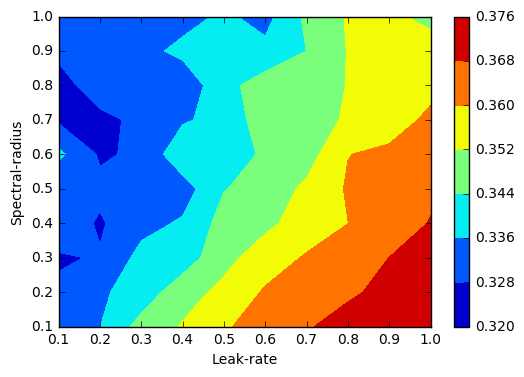

In [34]:
from matplotlib import pyplot
%matplotlib inline
pyplot.contourf(np.repeat(l_rate_fast,len(l_rate_fast)).reshape(10,10),
                np.tile(sp_rad_fast, len(sp_rad_fast)).reshape(10,10),fast_errors_averaged_over_trials.reshape(10,10))
pyplot.xlabel("Leak-rate")
pyplot.ylabel("Spectral-radius")
pyplot.colorbar()